# Quadratic (Lapace) Approximation 
- PML Book 1, Chapter 4.6.8.2

## 1. Beta distribtuion

import torch 


In [1]:
import torch 
import scipy.special as special 
import numpy as np 
import scipy.stats as stats 
import matplotlib.pyplot as plt 
import seaborn as sns 

def pplot(x, y, title=None):
    plt.figure(figsize=(10,4))
    plt.plot(x.detach().numpy(), y.detach().numpy())
    plt.grid(True)
    plt.title(title)
    return plt 

In [2]:
x = torch.linspace(0, 1, 101, requires_grad=True)
x

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000], requires_grad=True)

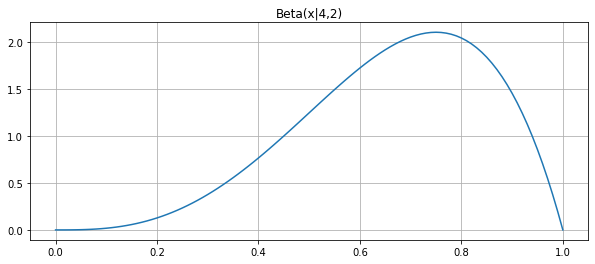

In [3]:
alpha, beta = 4, 2
def Pbeta(x):
    p = x**(alpha-1) * (1-x)**(beta-1) / special.beta(alpha, beta) 
    return p 
#
def pdfX(x):
    return Pbeta(x)

pbeta = Pbeta(x)
pplot(x, pbeta, title=f"Beta(x|{alpha},{beta})");

In [5]:
x[torch.argmax(pbeta)] # MAP estimate

tensor(0.7500, grad_fn=<SelectBackward0>)

## Quadratic approximation

tensor(0.7500, grad_fn=<SelectBackward0>)

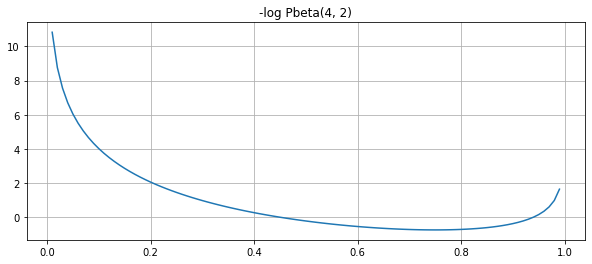

In [7]:
neglogP = -torch.log(Pbeta(x))
pplot(x, neglogP, title=f"-log Pbeta({alpha}, {beta})");
x[ torch.argmin(neglogP) ]

In [15]:
xhat = (alpha - 1) / (alpha + beta - 2)
xstar = torch.tensor(xhat, requires_grad=True)  # actually this value need to be computed.
nlogp = - torch.log(Pbeta(xstar))
xstar, nlogp

(tensor(0.7500, requires_grad=True), tensor(-0.7464, grad_fn=<NegBackward0>))

In [16]:
eps=0.0001
-torch.log(Pbeta(xstar + eps)), -torch.log(Pbeta(xstar)), -torch.log(Pbeta(xstar + eps))

(tensor(-0.7464, grad_fn=<NegBackward0>),
 tensor(-0.7464, grad_fn=<NegBackward0>),
 tensor(-0.7464, grad_fn=<NegBackward0>))

The gradient at $x^*$ is 0.

So is the output from torch.autograd.

In [17]:
def negLogFunc(x):
    return -torch.log(Pbeta(x))
torch.autograd.functional.jacobian(negLogFunc, xstar)

tensor(0.)

'backward()` may also be used to compute the gradient at x

In [18]:
nlogp.backward() # compute d nlogp / dx @ x_MAP
xstar, xstar.grad 

(tensor(0.7500, requires_grad=True), tensor(0.))

In [19]:
print(f"xstar.grad = {xstar.grad} # almost zero?")
d_nlogp_dx = xstar.grad 

xstar.grad = 0.0 # almost zero?


In [22]:
def Ufunc(x):
    return -torch.log(Pbeta(x))
#
H = torch.autograd.functional.hessian(Ufunc, xstar)
H 

tensor(21.3333)

In [23]:
# Normalizing constant.
Z = (torch.pi)**(1./2) * torch.abs(1./H)**(-1./2)
Z

tensor(8.1866)

`CLASS torch.distributions.normal.Normal(loc, scale, validate_args=None)`
- loc (float or Tensor) – mean of the distribution (often referred to as mu)
- scale (float or Tensor) – standard deviation of the distribution (often referred to as sigma)

https://pytorch.org/docs/stable/distributions.html#normal

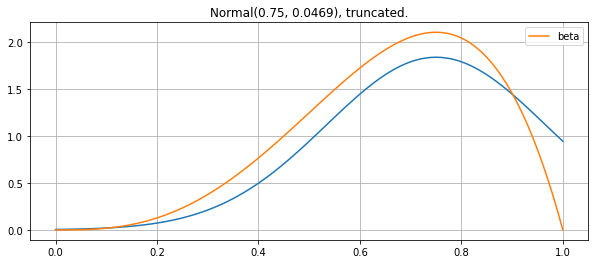

In [25]:
# Quadratic Approximation
meanhat = xstar 
Varhat = 1./ H 

normalhat = torch.distributions.Normal(meanhat, torch.sqrt(Varhat))
plt = pplot(x, torch.exp(normalhat.log_prob(x)), title=f"Normal({meanhat:.2}, {Varhat:.3}), truncated.")
plt.plot(x.detach().numpy(), pbeta.detach().numpy(), label='beta')
plt.legend();

In [27]:
meanhat, Varhat

(tensor(0.7500, requires_grad=True), tensor(0.0469))

## Let's apply quadratic approxation in logit space.

$$   y = \log\frac{\theta}{1-\theta} $$

$$ p_Y(y) = p_X(\theta(y)) \bigg|\frac{d\theta}{dy}\bigg|_{\theta=\theta(y)} $$

In [28]:
def theta(y):
    return torch.sigmoid(y)
def logit(theta):
    return torch.logit(theta)

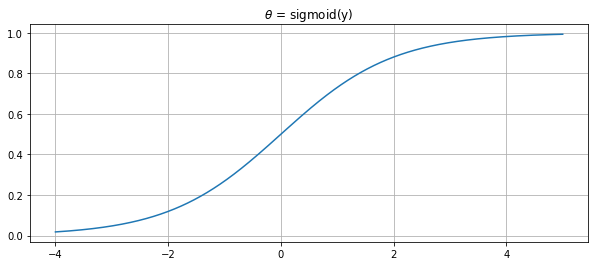

In [29]:
y = torch.linspace(-4,5,12001)
pplot(y, theta(y), title='$\\theta$ = sigmoid(y)');

In [30]:
alpha, beta = 4,2
def pdfX(x): # exact PDF
    return x**(alpha-1) * (1-x)**(beta-1) / special.beta(alpha,beta)

In [31]:
x = torch.linspace(0,1,10001)
xhat = x[ torch.argmax(pdfX(x)) ]
mode = (alpha - 1) / (alpha + beta - 2)
xhat  , mode

(tensor(0.7500), 0.75)

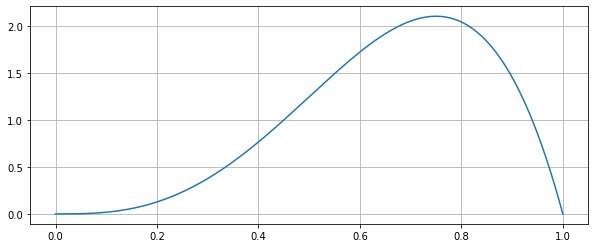

In [32]:
pplot(x, pdfX(x));

In [33]:
def pdfY(y):
    # pdfX(theta(y)) * | dt/dy |
    py = pdfX(theta(y)) * torch.abs(theta(y)*(1-theta(y)))
    return py 

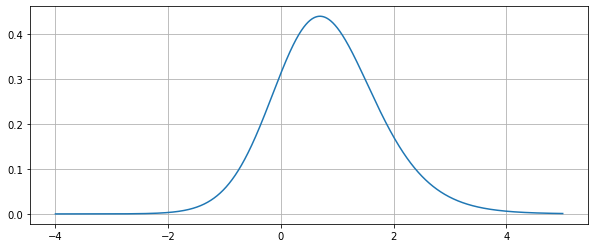

In [34]:
pplot(y, pdfY(y));

In [40]:
logit(xhat), xhat

(tensor(1.0986), tensor(0.7500))

In [41]:
yhat = y[ torch.argmax(pdfY(y)) ]  # numerically computed (on grids).
yhat , theta(yhat), logit(xhat)   # xhat and theta(yhat) are different.

(tensor(0.6927), tensor(0.6666), tensor(1.0986))

In [44]:
pdfY(logit(xhat)), pdfY(yhat) # the max location has changed through the nonlinear transformation. logit(xhat) is not the maximum location.

(tensor(0.3955), tensor(0.4390))

In [45]:
yhat.requires_grad_ = True 
print(f"yhat: {yhat}")

yhat: 0.6927499771118164


In [46]:
torch.autograd.functional.jacobian(pdfY, yhat)

tensor(0.0002)

In [61]:
yhat_update = yhat 
lr = 0.54321
for i in range(10):
    g = torch.autograd.functional.jacobian(pdfY, yhat_update)
    yhat_update = yhat_update + lr * g 
    print(g)
print(yhat_update, yhat)
yhat = yhat_update # updated!

tensor(0.0002)
tensor(0.0002)
tensor(0.0001)
tensor(7.3895e-05)
tensor(5.0187e-05)
tensor(3.4317e-05)
tensor(2.3499e-05)
tensor(1.5974e-05)
tensor(1.0908e-05)
tensor(7.3165e-06)
tensor(0.6931) tensor(0.6927)


In [63]:
def negLogPdfY(y):
    return -torch.log(pdfY(y))
#
H = torch.autograd.functional.hessian(negLogPdfY, yhat)
print(f"Hessian: {H:.3}  @  yhat={yhat:.4}")

Hessian: 1.33  @  yhat=0.6931


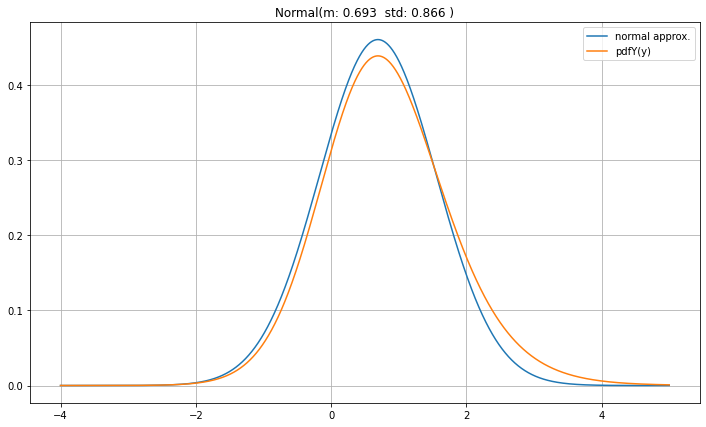

In [64]:
# normal approximation
normalAppro = torch.distributions.Normal(yhat, torch.sqrt(1./H))

plt.figure(figsize=(12,7))
plt.plot(y.detach().numpy(), torch.exp(normalAppro.log_prob(y)).detach().numpy(), label='normal approx.')
plt.plot(y.detach().numpy(), pdfY(y).detach().numpy(), label='pdfY(y)')
plt.grid(True)
plt.title(f"Normal(m: {yhat:.3}  std: {torch.sqrt(1./H):.3} )")
plt.legend();

End.